## Diabetic retinopathy: image processing via CLAHE

Date created: Jan 20, 2018   
Last modified: Feb 19, 2018  
Tags: CLAHE, RGB images, diabetic retinopathy, image processing   
About: Enhancing image contrast in diabetic retinopathy fundus images; applying the OpenCV implementation of CLAHE to RGB images.

A diabetic retinopathy (DR) dataset, sourced from different locations and with different camera equipment, has images of varying brightness, contrast and resolution. For deep learning systems built to automate the identification of DR, preprocessing entails cropping the images to the <a href="https://en.wikipedia.org/wiki/Fundus_(eye)">fundus</a> (the object of interest), resizing the images to meet a uniform size specification, normalizing the images and enhancing the image contrast to better identify distinguishing features.
For this last, CLAHE, which stands for *Contrast Limited Adaptive Histogram Equalization*, is applied. The fundus images are RGB images so the treatment is a little different than for grayscale X-Ray, MRI or CT images one usually deals with in medical imaging. 

In this exercise we will apply an OpenCV implementation of CLAHE to retinal fundus images, vary two of the paramters (clip limit and tile size) and compare the results with the original image. 

The notebook is organized into the following sections:  
  1. [Data](#Data) 
  2. [Crop, resize and display fundus images](#Crop) 
  3. [CLAHE,](#CLAHE_intro) a brief introduction 
  4. [Experiment with CLAHE parameters](#CLAHE_experiment)
 

## Data
<a id='Data'></a>
The data comes from the [Kaggle Diabetic Retinopathy](https://www.kaggle.com/c/diabetic-retinopathy-detection) training [dataset](https://www.kaggle.com/c/diabetic-retinopathy-detection/data). For each subject, there is a left and a right eye image. The images were taken under a variety of imaging conditions and may be overexposed, underexposed, inverted, noisy or vary in resolution. The five image categories reflect the stages of DR progression. These classes are: 
-  Level 0: No DR 
-  Level 1: Mild
-  Level 2: Moderate 
-  Level 3: Severe 
-  Level 4: Proliferative DR 

#### Load libraries

In [16]:
import os

import numpy as np
import pandas as pd


import PIL
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.io.parsers import read_csv

In [17]:
data_dir = '../input/'

In [18]:
# read the class labels
df = pd.read_csv(data_dir + 'trainLabels.csv')

# tabulate the class frequency
df.level.value_counts().to_frame(name='count').T

,0,2,1,3,4
count,25810,5292,2443,873,708


In [20]:
df = df.query('image in {0}'\
              .format([_.replace('.jpeg', '') for _ in os.listdir('../input/')]))

# show first 10 images and the associated labels
df.iloc[0:10]

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


<a id='Crop'></a>
## Crop, resize and display images

Code from https://www.kaggle.com/alfrandom/data-visualization

In [21]:
def img_to_array(img):
    return np.array(img.getdata()).reshape(img.width, img.width, 3) / 255


def trim(im):
    """trim black margin, 
    http://stackoverflow.com/questions/10615901/trim-whitespace-using-pil"""
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -20)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)


def calc_thumbnail_size(img):
    """calculate thumbnail size with constant aspect ratio"""
    width, length = img.size
    ratio = width / length

    # for some reason, if it's exactly 224, then thumnailed image is 223
    dim = 224 + 1          # output dim
    if ratio > 1:
        size = (dim * ratio, dim)
    else:
        size = (dim, dim / ratio)
    return size


def calc_crop_coords(img):
    """crop to square of desired dimension size"""
    dim = 224
    width, length = img.size
    left = 0
    right = width
    bottom = length
    top = 0
    if width > dim:
        delta = (width - dim) / 2
        left = delta
        right = width - delta
    if length > dim:
        delta = (length - dim) / 2
        top = delta
        bottom = length - delta
    return (left, top, right, bottom)


def preprocess(img):
    img = trim(img)
    tsize = calc_thumbnail_size(img)
    img.thumbnail(tsize)
    crop_coords = calc_crop_coords(img)
    img = img.crop(crop_coords)
    return img

#### Display images

Five images from each of the five classes, twenty-five in all, are displayed. Note the intraclass variability in images.

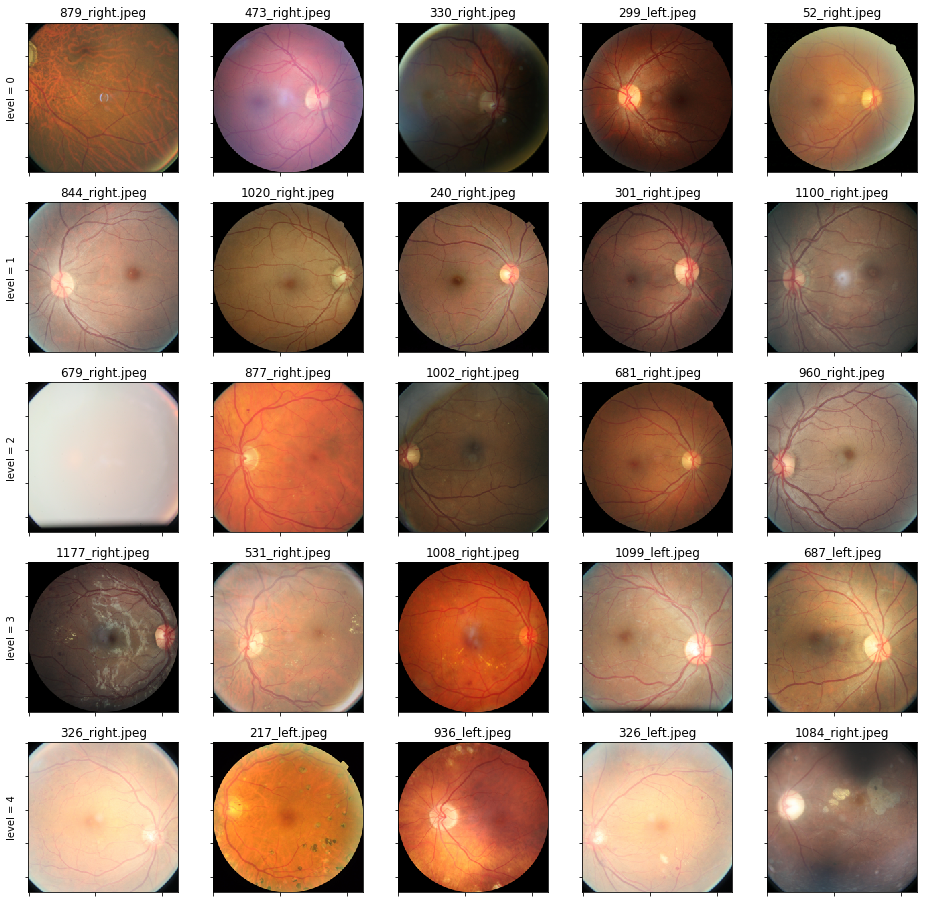

In [22]:
imgs_with_label = []
n_samples = 5

# for each class (label = 0,1,2,3,4)
for i in range(5):   
    _vals = df.query('level == {0}'.format(i)).sample(n_samples).image.apply(
        lambda v: (os.path.join(data_dir, v) + '.jpeg', i)).values.tolist()
    imgs_with_label.extend(_vals)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.ravel()
for k, (img, label) in enumerate(imgs_with_label):
    im = PIL.Image.open(img)
    im = preprocess(im)
    ax = axes[k]
    ax.imshow(img_to_array(im))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    if k % 5 == 0:
        ax.set_ylabel('level = {0}'.format(label))
    ax.set_title(os.path.basename(img))

<a id='CLAHE_intro'></a>
## CLAHE


#### Histogram Equalization
[Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) (HE) is a method that increases the global contrast of low-contrast images. A transform redistributes the intensities across the entire dyanamic range of the image and this has the effect of increasing the foreground-background difference.

#### AHE 
The HE transformation is applied globally to all pixels in an image. Often local regions in an image are much lighter or darker than other regions. Computing a different HE transform for each of these local regions will improve the overall contrast. This procedure is called [Adaptive Histogram Equalization](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) or AHE. The *tile size*, the size of the neighborhood region is a parameter used by this algorithm. A limitation of AHE is that it can overamplify noise in homogeneous regions of the image.

#### CLAHE
The [Contrast Limited Adaptive Histogram Equalization](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) (CLAHE) algorithm is an improved version of AHE. Here the contrast amplification is clipped so as to reduce the problem of noise amplification. This introduces another parameter, the  *clip limit*, which is the value at which the histogram is clipped.   
CLAHE was originally developed for medical imaging <a href="#ref1">[1]</a> and is now a part of the radiology image processing work flow. [This](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) tutorial nicely shows how CLAHE is applied on grayscale images with OpenCV. 

####  CLAHE for RGB images
Applying HE or (AHE or CLAHE) directly to an RGB image affects the relative distributions of the color channels and this may dramatically impact the image's overall color balance. The correct procedure is to convert the image to another color space (e.g. Lab color space or HSL/HSV), isolate the luminance or value channel and then apply the HE algorithm.

In [23]:
def clahe_rgb(img_path, cliplimit=None, tilesize=8):
    
    """ 
    For RGB images, the image is first converted to the LAB format, 
    and then CLAHE is applied to the isolated L channel.
    Input:
      img_path: path to the image file
      cliplimit: the high contrast limit applied to CLAHE processing; this value is often 2, 3 or 4.
      tilesize: defines the local neighborhood for histogram equalization
    Returns:
      bgr: image after CLAHE processing
    """
 
    bgr = cv2.imread(img_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit,tileGridSize=(tilesize, tilesize))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr

<a id='CLAHE_experiment'></a>
## Experiments with CLAHE

We experiment with the *tilesize* (8,16,32) and *cliplimit* (2, 3, 4) parameters to find which pair of values best highlights the vasculature, microaneurysms and other features used in identifying pathology.

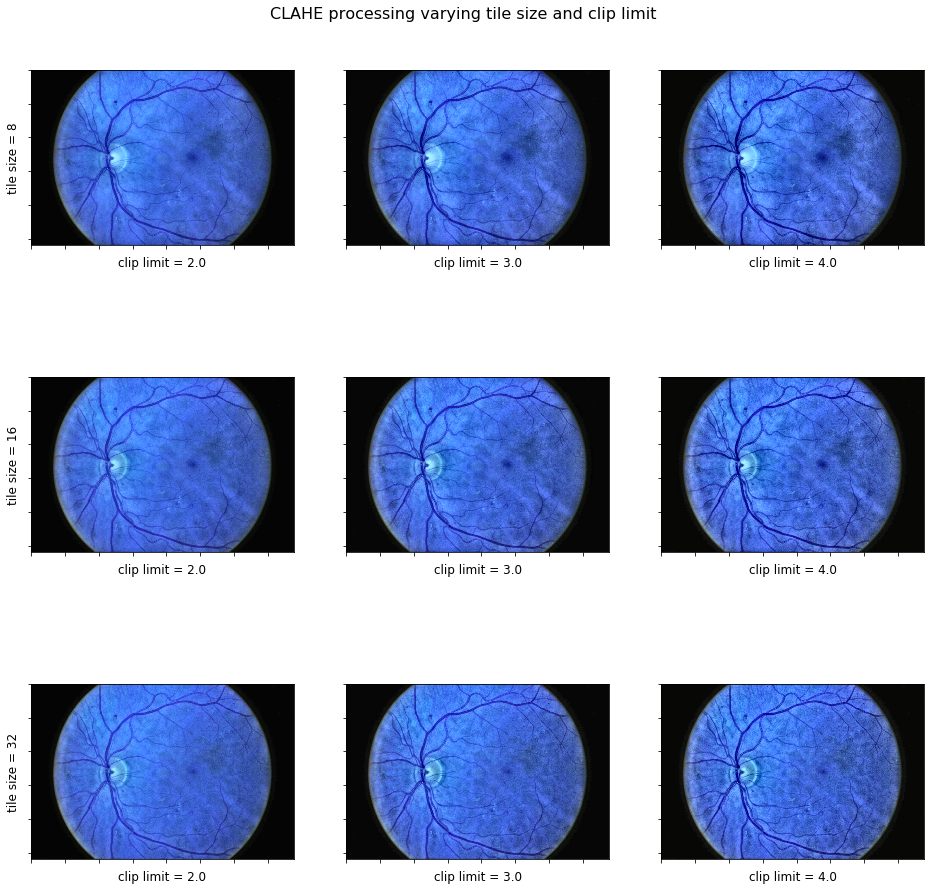

In [24]:
# apply clahe_rgb, varying tilesize and cliplimit, to an image

img_path = imgs_with_label[11][0]  # select an image from level 2
input_img = cv2.imread(img_path)
tilesize = [8,16,32]
cliplimit = [2.0, 3.0, 4.0]

fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.ravel()
fig.suptitle("CLAHE processing varying tile size and clip limit", y=0.9, fontsize=16)

k = 0
for ts in tilesize:
    for j in cliplimit:
        bgr  = clahe_rgb(img_path, cliplimit=j, tilesize=ts)
        ax = axes[k]
        ax.imshow(bgr)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
   
        if k % 3 == 0:
            ax.set_ylabel('tile size = {0}'.format(ts), fontsize=12)
        ax.set_xlabel('clip limit = {0}' .format(j), fontsize=12)
        
        k +=1                

The best image was produced for the tilesize = 16 and cliplimit = 3.0 or 4.0 settings. Below we compare the original image with the CLAHE enhanced image when tilesize=16, cliplimit = 4.0.

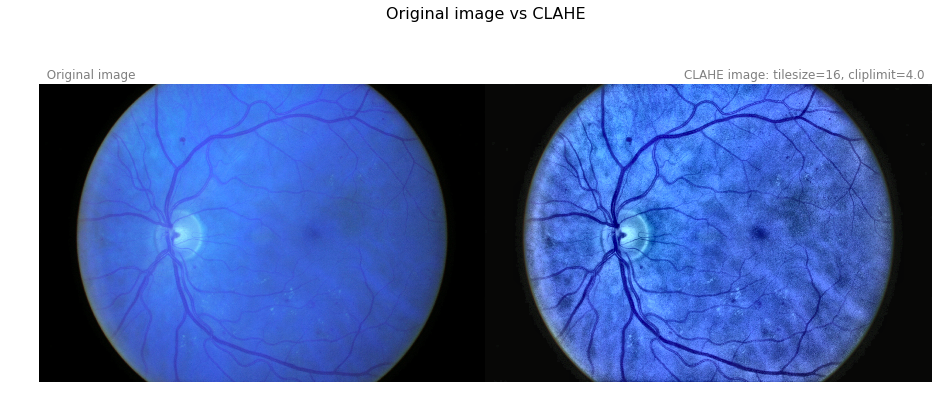

In [27]:
bgr  = clahe_rgb(img_path, cliplimit=4.0, tilesize=16)  
v = np.hstack((input_img, bgr))
plt.figure(figsize=(16,16))              
plt.imshow(v)
plt.axis('off')
plt.title('Original image vs CLAHE', y=1.2, fontsize=16)
plt.title('CLAHE image: tilesize=16, cliplimit=4.0  ', color='gray', loc='right')
plt.title('  Original image', color='gray', loc='left');

## References and Further Reading

<a name="ref1"></a>[1] [S. M. Pizer, E. P. Amburn, J. D. Austin, et al. "Adaptive Histogram Equalization and Its Variations." Computer Vision, Graphics, and Image Processing 39 (1987) 355-368.](http://www.cs.unc.edu/~smp/PizerPubs)

[2] [Diabetic retinopathy | Endocrine system diseases | NCLEX-RN | Khan Academy," YouTube video posted by "khanacademymedicine", May 14, 2015.](https://www.youtube.com/watch?v=VIrkurR446s)

<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
Email:   meenas.mailbag@gmail.com   <br> 
Twitter: @meena_uvaca    <br>
</div>